<h1, align = "center"> Stock Price Prediction with Twitter Sentiment Analysis Data using Long-short term memory </h1>

<h3>_by Ann, Gunjan and Divya_ / [Github](https://github.com/NEU-BDIA-ADG/Stock_Market_Prediction-using-LSTM)</h3>

In this notebook, we tried to train the LSTM with sentimental measures calculated from Alien api. It follwed the same steps as in "**LSTM.ipynb**" except the sentiment measure which was correlated with the corresponding dates of the stock data. But the model gave poor result insipte of tunning the parameters.

In [1]:
import csv
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from numpy import concatenate
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import *
from math import sqrt
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from decimal import *

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Creating two different dataset one with stock data and other one with tweets.

In [2]:
#Stock Data for Apple
df_1 = pd.read_csv("APPLE_for_tweet.csv")
#Twitter data for Apple
df_2 = pd.read_csv("SampleTweets.csv")

In [3]:
df_1.head()

,date,close,volume,open,high,low
0,19-05-2017,153.06,26892850,153.38,153.98,152.63
1,18-05-2017,152.54,33520150,151.27,153.34,151.13
2,17-05-2017,150.25,50674280,153.60,154.57,149.71
3,16-05-2017,155.47,19994270,155.94,156.06,154.72
4,15-05-2017,155.70,25912270,156.01,156.65,155.05


In [4]:
df_2.head()

,sentiment,date,tweets,weights
0,|neutral|,19-05-2017,RT @Sandro_power: $AAPL $BABA will hold these...,0.0
1,NaN,NaN,NaN,NaN
2,|positive|,19-05-2017,RT @mytradingbuddy: #Stocks #Traders LEARN Th...,2.0
3,NaN,NaN,NaN,NaN
4,|neutral|,19-05-2017,Apple’s $AAPL Nokia Suit More Pressing Than Q...,0.0


The twitter dataframe had multiple NaN values while extracting it from csv. Hence removing the NaN values.

In [5]:
df_2 = df_2.dropna()
df_2.head()

,sentiment,date,tweets,weights
0,|neutral|,19-05-2017,RT @Sandro_power: $AAPL $BABA will hold these...,0.0
2,|positive|,19-05-2017,RT @mytradingbuddy: #Stocks #Traders LEARN Th...,2.0
4,|neutral|,19-05-2017,Apple’s $AAPL Nokia Suit More Pressing Than Q...,0.0
6,|positive|,19-05-2017,#validate #organic #strategies at https://t.c...,5.0
8,|neutral|,19-05-2017,RT @kirillklip: InvestorIntel: International ...,0.0


In [6]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489 entries, 0 to 976
Data columns (total 4 columns):
sentiment    489 non-null object
date         489 non-null object
tweets       489 non-null object
weights      489 non-null float64
dtypes: float64(1), object(3)
memory usage: 19.1+ KB


Changing the datatype of "date" column in both dataset.

In [6]:
df_1['date'] = pd.to_datetime(df_1['date'])
df_2['date'] = pd.to_datetime(df_2['date'])

For particular gien date there were number of tweets along with its measure. But we can correlate the sentiment measure with the stock data only with one dominant value. Hence segregating all the dates as different dataset and calculating the mean value to fix a single value for a particular date. This value later will be assigned to the stock dataframe with corresponding dates.

In [7]:
df_19 = df_2[df_2['date'] == '19-05-2017']
df_18 = df_2[df_2['date'] == '18-05-2017']
df_17 = df_2[df_2['date'] == '17-05-2017']
df_16 = df_2[df_2['date'] == '16-05-2017']
df_15 = df_2[df_2['date'] == '15-05-2017']

The sentiment measures distribution illustrates, the variance in the sentiment values even when its analysis states a particular class such positive.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013F093AB780>]],
      dtype=object)

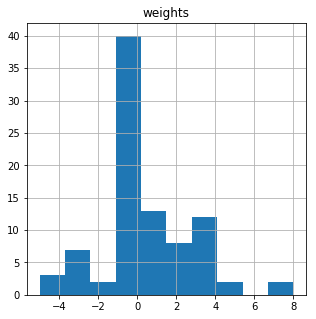

In [9]:
df_19.hist(column='weights', figsize = (5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013F0B420C50>]],
      dtype=object)

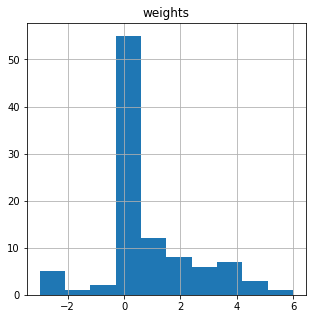

In [10]:
df_18.hist(column='weights', figsize = (5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013F093996D8>]],
      dtype=object)

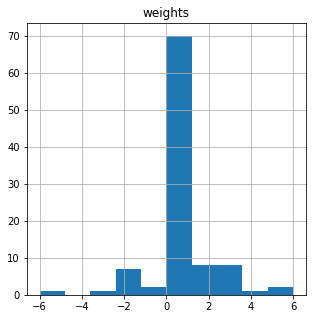

In [11]:
df_17.hist(column='weights', figsize = (5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013F0B648208>]],
      dtype=object)

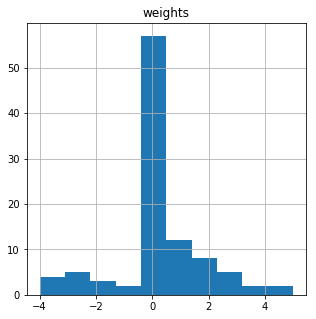

In [12]:
df_16.hist(column='weights', figsize = (5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013F0B6D3048>]],
      dtype=object)

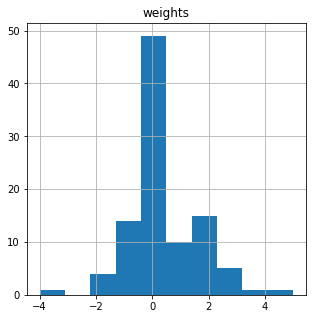

In [13]:
df_15.hist(column='weights', figsize = (5,5))

In [14]:
x = [df_19.weights.mean(),df_18.weights.mean(), df_17.weights.mean(), df_16.weights.mean(),df_15.weights.mean()]

data = [float(Decimal("%.2f" % e)) for e in x]

df_1['weights'] = data

In [15]:
df_1 = df_1.set_index(['date'])
df_1 = df_1.rename(columns={'open':'prevday_open'})
df_1['open'] = df_1['prevday_open']
df_1.prevday_open = df_1.prevday_open.shift(-1)
df_1 = df_1.fillna(df_1.mean()['prevday_open'])

The same data cleaning steps followed from **LSTM.ipybn**.

In [2]:
df = pd.read_csv("APPL_PrevOpenPrice.csv")

In [3]:
df_nopreopen = pd.read_csv("APPL_NoPrevOpenPrice.csv")

In [9]:
df.head()

,close,volume,prevday_open,high,low,open
date,,,,,,
2018-04-17,178.24,26575010.0,175.0301,178.9365,176.4100,177.8100
2018-04-16,175.82,21561320.0,174.7800,176.1900,174.8301,176.4900
2018-04-13,174.73,25100510.0,173.4100,175.8400,173.8500,175.0301
2018-04-12,174.14,22858840.0,172.2300,175.0000,173.0400,174.7800
2018-04-11,172.44,22401040.0,173.0000,173.9232,171.7000,173.4100


In [10]:
df_nopreopen.head()

,close,volume,high,low,open
date,,,,,
2018-04-17,178.24,26575010.0,178.9365,176.4100,177.8100
2018-04-16,175.82,21561320.0,176.1900,174.8301,176.4900
2018-04-13,174.73,25100510.0,175.8400,173.8500,175.0301
2018-04-12,174.14,22858840.0,175.0000,173.0400,174.7800
2018-04-11,172.44,22401040.0,173.9232,171.7000,173.4100


In [5]:
df = df.reset_index(drop=True)
df = df.drop(df.index[0])

In [6]:
df_nopreopen = df_nopreopen.reset_index(drop=True)
df_nopreopen = df_nopreopen.drop(df_nopreopen.index[0])

In [7]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date'])

In [8]:
df_nopreopen['date'] = pd.to_datetime(df_nopreopen['date'])
df_nopreopen = df_nopreopen.set_index(['date'])

In [54]:
size= len(df)

In [55]:
df['weights'] = np.random.random((size,1))
df_nopreopen['weights'] = df['weights']

In [22]:
df = df.rename(columns={'open':'prevday_open'})
df['open'] = df['prevday_open']
df.prevday_open = df.prevday_open.shift(-1)
df = df.fillna(df.mean()['prevday_open'])
old_df = df

In [56]:
arrange = df_nopreopen.columns.tolist()
arrange.remove('open')
arrange.append('open')
df_nopreopen = df_nopreopen[arrange]
old_df_nopreopen = df_nopreopen

In [57]:
arrange = df.columns.tolist()
arrange.remove('open')
arrange.append('open')
df = df[arrange]
old_df = df

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2018-04-18 to 2013-04-18
Data columns (total 7 columns):
close           1260 non-null float64
volume          1260 non-null object
prevday_open    1260 non-null float64
high            1260 non-null float64
low             1260 non-null float64
weights         1260 non-null float64
open            1260 non-null float64
dtypes: float64(6), object(1)
memory usage: 78.8+ KB


Now the datasets are ready to for normalisation

### Prediction Model

In [58]:
from sklearn import preprocessing
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['prevday_open'] = min_max_scaler.fit_transform(df.prevday_open.values.reshape(-1,1))
    df['open'] = min_max_scaler.fit_transform(df['open'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,close,volume,prevday_open,high,low,weights,open
date,,,,,,,
2018-04-17,0.972366,0.059252,0.940551,0.963900,0.969648,0.251099,0.962411
2018-04-16,0.953149,0.039577,0.938584,0.942174,0.957028,0.339892,0.952031
2018-04-13,0.944493,0.053466,0.927811,0.939406,0.949200,0.496003,0.940551
2018-04-12,0.939808,0.044669,0.918531,0.932761,0.942730,0.504319,0.938584
2018-04-11,0.926308,0.042873,0.924587,0.924243,0.932026,0.985406,0.927811


In [59]:
def normalize_data_nopreopen(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['open'] = min_max_scaler.fit_transform(df['open'].values.reshape(-1,1))
    return df
df_nopreopen = normalize_data_nopreopen(df_nopreopen)
df_nopreopen.head()

,close,volume,high,low,weights,open
date,,,,,,
2018-04-17,0.972366,0.059252,0.963900,0.969648,0.251099,0.962411
2018-04-16,0.953149,0.039577,0.942174,0.957028,0.339892,0.952031
2018-04-13,0.944493,0.053466,0.939406,0.949200,0.496003,0.940551
2018-04-12,0.939808,0.044669,0.932761,0.942730,0.504319,0.938584
2018-04-11,0.926308,0.042873,0.924243,0.932026,0.985406,0.927811


In [36]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [60]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [61]:
window = 20
X_train, y_train, X_test, y_test = load_data(df, window)
X_train1, y_train1, X_test1, y_test1 = load_data(df_nopreopen, window)
print (X_train[0], y_train[0])

[[0.9723656  0.0592524  0.94055079 0.96390044 0.96964752 0.25109932
  0.96241125]
 [0.95314857 0.0395775  0.93858407 0.94217426 0.95702808 0.33989174
  0.95203109]
 [0.94449297 0.05346612 0.92781072 0.93940559 0.94919953 0.49600295
  0.94055079]
 [0.93980783 0.04466927 0.91853149 0.93276077 0.94272966 0.50431879
  0.93858407]
 [0.92630827 0.04287276 0.92458658 0.92424275 0.93202642 0.98540644
  0.92781072]
 [0.93274041 0.06706987 0.90005166 0.92485027 0.93066855 0.44219918
  0.91853149]
 [0.90732947 0.06867524 0.90862316 0.91765172 0.91720962 0.91310833
  0.92458658]
 [0.89406813 0.09211663 0.92128381 0.91282632 0.90407019 0.34261158
  0.90005166]
 [0.929167   0.05994012 0.86073289 0.92667285 0.93506167 0.64177043
  0.90862316]
 [0.9197173  0.09067314 0.88243685 0.90910838 0.87667308 0.64613474
  0.92128381]
 [0.89414754 0.07362543 0.88432415 0.88328457 0.87755171 0.72805894
  0.86073289]
 [0.88056857 0.10183284 0.88373437 0.88482316 0.87427683 0.45759269
  0.88243685]
 [0.88930358 0.1

In [62]:
model = build_model([7,window,1])
model1 = build_model([6,window,1])

Compilation Time :  0.03709912300109863
Compilation Time :  0.023563146591186523


In [63]:
model.fit(X_train,y_train,batch_size=512,epochs=100,validation_split=0.1,verbose=1)

Train on 1002 samples, validate on 112 samples
Epoch 1/100
1002/1002 [==============================] - 5s 5ms/step - loss: 0.3130 - acc: 0.0000e+00 - val_loss: 0.0245 - val_acc: 0.0000e+00
Epoch 2/100
1002/1002 [==============================] - 2s 2ms/step - loss: 0.2816 - acc: 0.0000e+00 - val_loss: 0.0156 - val_acc: 0.0000e+00
Epoch 3/100
1002/1002 [==============================] - 2s 2ms/step - loss: 0.1826 - acc: 0.0000e+00 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 4/100
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0494 - acc: 9.9800e-04 - val_loss: 0.1940 - val_acc: 0.0000e+00
Epoch 5/100
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0622 - acc: 9.9800e-04 - val_loss: 0.2419 - val_acc: 0.0000e+00
Epoch 6/100
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0557 - acc: 9.9800e-04 - val_loss: 0.1490 - val_acc: 0.0000e+00
Epoch 7/100
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0410 - acc: 0.00

In [64]:
model1.fit(X_train1,y_train1,batch_size=512,epochs=100,validation_split=0.1,verbose=1)

Train on 1002 samples, validate on 112 samples
Epoch 1/100
1002/1002 [==============================] - 5s 5ms/step - loss: 0.3122 - acc: 0.0000e+00 - val_loss: 0.0241 - val_acc: 0.0000e+00
Epoch 2/100
1002/1002 [==============================] - 2s 2ms/step - loss: 0.2786 - acc: 0.0000e+00 - val_loss: 0.0141 - val_acc: 0.0000e+00
Epoch 3/100
1002/1002 [==============================] - 2s 2ms/step - loss: 0.1728 - acc: 0.0000e+00 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 4/100
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0434 - acc: 9.9800e-04 - val_loss: 0.2222 - val_acc: 0.0000e+00
Epoch 5/100
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0678 - acc: 9.9800e-04 - val_loss: 0.2295 - val_acc: 0.0000e+00
Epoch 6/100
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0534 - acc: 9.9800e-04 - val_loss: 0.1331 - val_acc: 0.0000e+00
Epoch 7/100
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0413 - acc: 9.98

In [65]:
p = model.predict(X_test)
p1 = model1.predict(X_test1)

### Error metrics with previous day open price

In [66]:
# Bug fixed at here, please update the denormalize function to this one
def denormalize(df, normalized_value): 
    df = df['open'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(old_df, p)
newy_test = denormalize(old_df, y_test)
newp1= denormalize(old_df_nopreopen,p1)
newy_test1 =denormalize(old_df_nopreopen,y_test1)

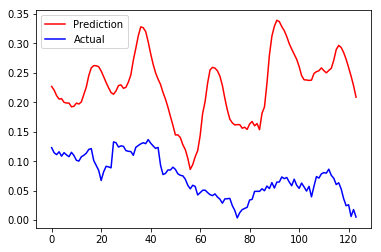

In [67]:
import matplotlib.pyplot as plt
plt.plot(newp,color='red', label='Prediction')
plt.plot(newy_test,color='blue', label='Actual')
plt.legend(loc='best')

plt.show()

In [68]:
summary_test = pd.DataFrame(index={'MAE', 'MAPE', 'RMSE', 'R2'})
def determineAnalysis(true, pred, regressor): 
    mae = mean_absolute_error(true, pred)
    rmse = sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    true, pred = np.array(true), np.array(pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    print('Mean absolute error is ',mae)
    print('Mean absolute percentage error is ',mape)
    print('Root mean squared error is ',rmse)
    print('RSquare is ',r2)
    return mae,mape,rmse,r2

mae,mape,rmse,r2 = determineAnalysis(newy_test, newp, model)

Mean absolute error is  0.1522760209588008
Mean absolute percentage error is  364.45112352524575
Root mean squared error is  0.16290754308412192
RSquare is  -20.972789374579666


### Error metrics without previous day open price

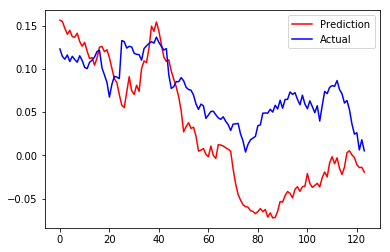

In [69]:
import matplotlib.pyplot as plt
plt.plot(newp1,color='red', label='Prediction')
plt.plot(newy_test1,color='blue', label='Actual')
plt.legend(loc='best')

plt.show()

In [70]:
mae,mape,rmse,r2 = determineAnalysis(newy_test1, newp1, model1)

Mean absolute error is  0.05383486621633398
Mean absolute percentage error is  122.91292853926976
Root mean squared error is  0.06471227986119746
RSquare is  -2.467178542276523


### Conclusion:

None of the model build with tweet senitments resulted with good or decent prediction. Hence considering LSTM with just stock data model better that with a model including senitment measures.